In [1]:

import matplotlib
matplotlib.use('Agg')
import os
import datetime
import numpy as np
import dill as pickle
import random
import sys
import seaborn as sns
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import rcParams
from collections import OrderedDict
import math
from matplotlib.lines import Line2D
from pylab import rcParams
from collections import Counter
from itertools import combinations

from shutil import copyfile
rcParams['figure.figsize'] = 25, 10

np.random.seed(0)
random.seed(0)
now = datetime.datetime.now().strftime("%B_%d_%Y_%H_%M_%S")
workingdirectory = os.popen('git rev-parse --show-toplevel').read()[:-1]
sys.path.append(workingdirectory)
os.chdir(workingdirectory)
from codes.experimentclasses.RigidEthanolPCA import RigidEthanolPCA
from codes.otherfunctions.get_dictionaries import get_all_atoms_4
from codes.otherfunctions.get_grads import get_grads
from codes.otherfunctions.multirun import get_support_recovery_lambda
from codes.otherfunctions.multirun import get_lower_interesting_lambda
from codes.otherfunctions.multirun import get_coeffs_and_lambdas
from codes.otherfunctions.multirun import get_support
from codes.otherfunctions.multiplot import plot_support_2d
from codes.otherfunctions.multiplot import plot_reg_path_ax_lambdasearch
from codes.otherfunctions.multiplot import plot_gs_v_dgnorm
from codes.otherfunctions.multiplot import plot_dot_distributions
from codes.otherfunctions.multirun import get_cosines
from codes.flasso.Replicate import Replicate
from codes.otherfunctions.multirun import get_olsnorm_and_supportsbrute
from codes.otherfunctions.multiplot import highlight_cell

#set parameters
n = 10000 #number of data points to simulate
nsel = 100 #number of points to analyze with lasso
itermax = 1000 #maximum iterations per lasso run
tol = 1e-10 #convergence criteria for lasso
#lambdas = np.asarray([0,.01,.1,1,10,100], dtype = np.float16)#lambda values for lasso
lambdas = np.asarray(np.hstack([np.asarray([0]),np.logspace(-3,1,11)]), dtype = np.float16)
n_neighbors = 1000 #number of neighbors in megaman
m = 3 #number of embedding dimensions (diffusion maps)
#diffusion_time = 1. #diffusion time controls gaussian kernel radius per gradients paper
diffusion_time = 0.05 #(yuchia suggestion)
dim = 2 #manifold dimension
dimnoise = 2
natoms = 9
cores = 3 #number of cores for parallel processing
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
cor = 0.0 #correlation for noise
var = 0.00001 #variance scaler for noise
ii = np.asarray([0,0,0,0,1,1,1,2]) # atom adjacencies for dihedral angle computation
jj = np.asarray([1,2,3,4,5,6,7,8])

#run experiment
atoms4 = np.asarray([[6,1,0,4],[4,0,2,8],[7,6,5,1],[3,0,2,4]],dtype = int)
nreps = 25
lambda_max = 1
max_search = 30

new_MN = True
new_grad = True
savename = 'rigidethanol_110120_alltorsions'
savefolder = 'rigidethanol'
loadfolder = 'rigidethanol'
loadname = 'rigidethanol_110120_alltorsions'



/Users/samsonkoelle/manifoldflasso_jmlr


In [2]:
#The true champion

import autograd.numpy as np
from autograd import jacobian
from autograd import elementwise_grad
from autograd import grad

import logging
from copy import deepcopy

#import numpy as np
from scipy.special import expit
from pyglmnet import utils


class GLM:
    
    def __init__(self, xs, ys, reg_lambda, group,max_iter, learning_rate, tol,parameter):
        self.xs = xs
        self.ys = ys
        self.reg_lambda = reg_lambda
        self.group = np.asarray(group)
        #print(self.group.shape)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.parameter = parameter
        self.l2loss = {}
        self.penalty = {}
        
    def _prox(self,beta, thresh):
        """Proximal operator."""
        
        #print(thresh, beta)
        #print('beginprox', beta[0:2],thresh)
        group_ids = np.unique(self.group)
        result = np.zeros(beta.shape)
        result = np.asarray(result, dtype = float)
        #print('gids',group_ids)
        for i in range(len(group_ids)):
            gid = i 
            #print(self.group)
            idxs_to_update = np.where(self.group == gid)[0]
            #print('idx',idxs_to_update)
            #print('norm', np.linalg.norm(beta[idxs_to_update]))
            if np.linalg.norm(beta[idxs_to_update]) > 0.:
                #print('in here', len(idxs_to_update))
                potentialoutput = beta[idxs_to_update] - (thresh / np.linalg.norm(beta[idxs_to_update])) * beta[idxs_to_update]
                posind = np.where(beta[idxs_to_update] > 0.)[0]
                negind = np.where(beta[idxs_to_update] < 0.)[0]
                po = beta[idxs_to_update].copy()
                #print('potention', potentialoutput[0:2])
                po[posind] = np.asarray(np.clip(potentialoutput[posind],a_min = 0., a_max = 1e15), dtype = float)
                po[negind] = np.asarray(np.clip(potentialoutput[negind],a_min = -1e15, a_max = 0.), dtype = float)
                result[idxs_to_update] = po
        #print('end', result[0:2])
        return result

    def _grad_L2loss(self, beta, X, y):
        #print(beta.shape,X.shape,y.shape)
        if y.ndim == 1:
            y = y[:, np.newaxis]
        n_samples = np.float(X.shape[0])
        z = np.dot(X, beta)
        #grad_beta = 1. / n_samples * np.transpose(np.dot(np.transpose(z - y), X))
        grad_beta = np.transpose(np.dot(np.transpose(z - y), X))
        #print('gb',grad_beta.shape)
        return grad_beta
    
    def _loss(self,beta, reg_lambda, X, y):
        """Define the objective function for elastic net."""
        L = self._logL(beta, X, y)
        P = self._L1penalty(beta)
        J = -L + reg_lambda * P
        return J
    
    def _logL(self,beta, X, y):
        """The log likelihood."""
        #print('beginlogL', np.linalg.norm(beta), np.linalg.norm(X), np.linalg.norm(y),y.shape,beta.shape,X.shape,)
        l = np.dot(X, beta)
        logL = -0.5 * np.sum((y - l)**2)
        #print('endlogL',logL)
        return logL
    
    def _L2loss(self,beta,X,y):
        #print('beginl2', np.linalg.norm(beta), np.linalg.norm(X), np.linalg.norm(y), y.shape)
        output = -self._logL(beta, X, y)
        #print('outl2',output)
        return(output)
    
    def _L1penalty(self, beta):
        """The L1 penalty"""
        # Compute the L1 penalty
        group = self.group
        group_ids = np.unique(self.group)
        L1penalty = 0.0
        for group_id in group_ids:
            L1penalty += np.linalg.norm(beta[self.group == group_id], 2)
        return L1penalty
    
    #def fhatlambda(self,lamb,x,y):
    def fhatlambda(self,lamb,betanew,betaold):
        xs = self.xs
        ys = self.ys
        #print(ys.shape,'fhatlam')
        #print(self._L2loss(betaold,xs,ys),self._L2loss(betanew,xs,ys),'old','new') 
        output = self._L2loss(betaold,xs,ys) + np.dot(self._grad_L2loss(betaold,xs,ys).transpose(),(betanew-betaold)) + (1/(2*lamb)) * np.linalg.norm(betanew-betaold)**2
        return(output)
    
    #_btalgorithm(yk,lamb,.5,1000, rl)
    def _btalgorithm(self,bet,lam,b,maxx,rl):
        
        #print('lam',lam)
        X = self.xs
        y = self.ys
        #print('beginbt', np.linalg.norm(y))
        #print('beginbt',self._L2loss(bet,X,y))
        #print(np.linalg.norm(bet))
        grad_beta = self._grad_L2loss(beta = bet, X = X, y = y)
        for i in range(maxx):
            #print('bt',i)
            betn = bet - lam * grad_beta
            z = self._prox(betn, lam * rl)
            fz = self._L2loss(z,X,y)
            #print(fz,'fz')
            fhatz = self.fhatlambda(lam,z, bet)
            if fz <= fhatz:
                print(i,'btiterstop')
            #print(fhatz - fz)
            #if 0 <= 1:
                break
            lam = b*lam
        return(z,lam)
    
    def fit(self):
        

        group  = self.group
        print(group.shape)
        lambdas = self.reg_lambda
        parameter = self.parameter
        X = self.xs
        #print(X.shape)
        y = self.ys
        
        np.random.RandomState(0)
        group = np.asarray(group, dtype = np.int64)

        #print(group.shape[0])
        group.dtype = np.int64
        #print(group.shape[0])
        #print(X.shape[1])
        if group.shape[0] != X.shape[1]:
            raise ValueError('group should be (n_features,)')

        # type check for data matrix
        if not isinstance(X, np.ndarray):
            raise ValueError('Input data should be of type ndarray (got %s).'
                             % type(X))

        n_features = np.float(X.shape[1])
        n_features = np.int64(n_features)
        if y.ndim == 1:
            y = y[:, np.newaxis]
            self.ys = y
        #print(y.shape)
        n_classes = 1
        n_classes = np.int64(n_classes)

        beta_hat = 1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        fit_params = list()
        
        for l, rl in enumerate(lambdas):
            fit_params.append({'beta': beta_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']
            tol = self.tol
            alpha = 1.
            beta = np.zeros([n_features, n_classes])
            beta = fit_params[-1]['beta']
            #print('losser',self._L2loss(beta,X,y))
            g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            lamb = self.learning_rate
            bm1 = beta.copy()
            bm2 = beta.copy()
            for t in range(0, self.max_iter):
                L.append(self._loss(beta, rl, X, y))
                L2.append(self._L2loss(beta,X,y))
                PEN.append(self._L1penalty(beta))
                w = (t / (t+ 3))
                yk = beta + w*(bm1 - bm2)
                #print('losser',self._L2loss(yk,X,y))
                #print('beforebt',np.linalg.norm(yk),np.linalg.norm(X),np.linalg.norm(y))
                beta , lamb = self._btalgorithm(yk,lamb,.5,1000, rl)
                #X = self.xs
                #y = self.ys
                #print('losser2',self._L2loss(beta,X,y))
                bm2 = bm1.copy()
                bm1 = beta.copy()
                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break
                    
            #print(beta)
            fit_params[-1]['beta'] = beta
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL
            #print(L)
        # Update the estimated variables
        
        self.fit_ = fit_params
        self.ynull_ = np.mean(y)

        # Return
        return self
 
#The true champion

# import sys
# !{sys.executable} -m pip install einops
from einops import rearrange

import autograd.numpy as np
from autograd import jacobian
from autograd import elementwise_grad
from autograd import grad

import logging
from copy import deepcopy

#import numpy as np
from scipy.special import expit
from pyglmnet import utils


class GradientGroupLasso:
    
    def __init__(self, dg_M, df_M, reg_l1s, reg_l2, max_iter,learning_rate, tol, beta0_npm= None):
        
        n = dg_M.shape[0]
        d= dg_M.shape[1]
        m = df_M.shape[2]
        p = dg_M.shape[2]
        dummy_beta = np.ones((n,p,m))
        
        self.dg_M = dg_M
        self.df_M = df_M
        self.reg_l1s = reg_l1s
        self.reg_l2 = reg_l2
        self.beta0_npm = beta0_npm
        self.n = n
        self.p = p
        self.m = m 
        self.d = d
        self.dummy_beta = dummy_beta
        #self.group = np.asarray(group)
        self.max_iter = max_iter
        self.learning_rate = learning_rate
        self.tol = tol
        self.Tau = None
        self.alpha = 1.
        self.lossresults = {}
        self.dls = {}
        self.l2loss = {}
        self.penalty = {}
        
    def _prox(self,beta_npm, thresh):
        """Proximal operator."""
        
        p = self.p
        result = np.zeros(beta_npm.shape)
        result = np.asarray(result, dtype = float)
        for j in range(p):
            if np.linalg.norm(beta_npm[:,j,:]) > 0.:
                potentialoutput = beta_npm[:,j,:] - (thresh / np.linalg.norm(beta_npm[:,j,:])) * beta_npm[:,j,:]
                posind = np.asarray(np.where(beta_npm[:,j,:] > 0.))
                negind = np.asarray(np.where(beta_npm[:,j,:] < 0.))
                po = beta_npm[:,j,:].copy()
                po[posind[0],posind[1]] = np.asarray(np.clip(potentialoutput[posind[0],posind[1]],a_min = 0., a_max = 1e15), dtype = float)
                po[negind[0],negind[1]] = np.asarray(np.clip(potentialoutput[negind[0],negind[1]],a_min = -1e15, a_max = 0.), dtype = float)
                result[:,j,:] = po
        return result

    def _grad_L2loss(self, beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        reg_l2 = self.reg_l2
        dummy_beta = self.dummy_beta
        
        df_M_hat = np.einsum('ndp,npm->ndm',dg_M, beta_npm)
        error = df_M_hat - df_M
        grad_beta = np.einsum('ndm,ndp->npm',error,dg_M) #+ reg_l2 * np.ones()
        #if 
        return grad_beta
    
    def _L1penalty(self, beta_npm):
        
        p = self.p
        m = self.m
        n = self.n 
        beta_mn_p = rearrange(beta_npm, 'n p m -> (m n) p')#np.reshape(beta_mnp, ((m*n,p)))
        L1penalty = np.linalg.norm(beta_mn_p, axis = 0).sum()
        
        return L1penalty
    
    def _loss(self,beta_npm, reg_lambda):
        """Define the objective function for elastic net."""
        L = self._logL(beta_npm)
        P = self._L1penalty(beta_npm)
        J = -L + reg_lambda * P
        return J
    
    def _logL(self,beta_npm):
        
        df_M = self.df_M
        dg_M = self.dg_M
        
        df_M_hat = np.einsum('ndp,npm -> ndm',dg_M, beta_npm)
        logL = -0.5 * np.linalg.norm((df_M - df_M_hat))**2
        return(logL)
    
    def _L2loss(self,beta_npm):
        output = -self._logL(beta_npm)
        return(output)

    def fhatlambda(self,learning_rate,beta_npm_new,beta_npm_old):

        output = self._L2loss(beta_npm_old) + np.einsum('npm,npm', self._grad_L2loss(beta_npm_old),(beta_npm_new-beta_npm_old)) + (1/(2*learning_rate)) * np.linalg.norm(beta_npm_new-beta_npm_old)**2
        
        return(output)

    def _btalgorithm(self,beta_npm ,learning_rate,b,maxiter_bt,rl):
        
        grad_beta = self._grad_L2loss(beta_npm = beta_npm)
        for i in range(maxiter_bt):
            beta_npm_postgrad = beta_npm - learning_rate * grad_beta
            beta_npm_postgrad_postprox = self._prox(beta_npm_postgrad, learning_rate * rl)
            fz = self._L2loss(beta_npm_postgrad_postprox)
            #fhatz = self.fhatlambda(lam,beta_npm_postgrad_postprox, beta_npm_postgrad)
            fhatz = self.fhatlambda(learning_rate,beta_npm_postgrad_postprox, beta_npm)
            if fz <= fhatz:
                print(i,learning_rate)
                break
            learning_rate = b*learning_rate    
            
        return(beta_npm_postgrad_postprox,learning_rate)
    
    def fit(self, beta0_npm = None):

        reg_l1s = self.reg_l1s
        n = self.n
        m = self.m
        p = self.p
        
        dg_M = self.dg_M
        df_M = self.df_M
        
        tol = self.tol
        np.random.RandomState(0)
        
        if beta0_npm is None:
            beta_npm_hat = 1 / (n*m*p) * np.random.normal(0.0, 1.0, [n, p,m])
            #1 / (n_features) * np.random.normal(0.0, 1.0, [n_features, n_classes])
        else: 
            beta_npm_hat = beta0_npm
            
        fit_params = list()
        for l, rl in enumerate(reg_l1s):
            fit_params.append({'beta': beta_npm_hat})
            if l == 0:
                fit_params[-1]['beta'] = beta_npm_hat
            else:
                fit_params[-1]['beta'] = fit_params[-2]['beta']
            
            alpha = 1.
            beta_npm_hat = fit_params[-1]['beta']
            #g = np.zeros([n_features, n_classes])
            L, DL ,L2,PEN = list(), list() , list(), list()
            learning_rate = self.learning_rate
            beta_npm_hat_1 = beta_npm_hat.copy()
            beta_npm_hat_2 = beta_npm_hat.copy()
            for t in range(0, self.max_iter):
                #print(t,l,rl)
                print(t)
                L.append(self._loss(beta_npm_hat, rl))
                L2.append(self._L2loss(beta_npm_hat))
                PEN.append(self._L1penalty(beta_npm_hat))
                w = (t / (t+ 3))
                beta_npm_hat_momentumguess = beta_npm_hat + w*(beta_npm_hat_1 - beta_npm_hat_2)
                
                beta_npm_hat , learning_rate = self._btalgorithm(beta_npm_hat_momentumguess,learning_rate,.5,1000, rl)
                #print(beta_npm_hat_momentumguess.max(), beta_npm_hat.max(),self._L2loss(beta_npm_hat), learning_rate)
                beta_npm_hat_2 = beta_npm_hat_1.copy()
                beta_npm_hat_1 = beta_npm_hat.copy()
                
                if t > 1:
                    DL.append(L[-1] - L[-2])
                    if np.abs(DL[-1] / L[-1]) < tol:
                        print('converged', rl)
                        msg = ('\tConverged. Loss function:'
                               ' {0:.2f}').format(L[-1])
                        msg = ('\tdL/L: {0:.6f}\n'.format(DL[-1] / L[-1]))
                        break

            fit_params[-1]['beta'] = beta_npm_hat
            self.lossresults[rl] = L
            self.l2loss[rl] = L2
            self.penalty[rl] = PEN
            self.dls[rl] = DL

        self.fit_ = fit_params
        #self.ynull_ = np.mean(y)

        return self
    
def get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate):
    
    highprobes = np.asarray([])
    lowprobes = np.asarray([])
    #lambdas_start = np.asarray([0,1])
    probe_init_low = lambdas_start[0]
    probe_init_high = lambdas_start[1]

    coeffs = {}
    combined_norms = {}

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_low]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= None)
    GGL.fit()
    beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_low] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_high]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= beta0_npm)
    GGL.fit(beta0_npm = beta0_npm)
    #beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_high] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_high] = np.sqrt((np.linalg.norm(coeffs[probe_init_high], axis = 0)**2).sum(axis = 1))

    n_comp = len(np.where(combined_norms[probe_init_high] != 0)[0])
    lowprobes = np.append(lowprobes, probe_init_low)

    if n_comp == card:
        #high_int = probe
        print('we did it')
        return (probe_init_high, coeffs, combined_norms)

    if n_comp < card:
        highprobes = np.append(highprobes, probe_init_high)
        probe = (lowprobes.max() + highprobes.min()) / 2
    if n_comp > card:
        lowprobes = np.append(lowprobes, probe_init_high)
        probe = lowprobes.max() * 2

    for i in range(max_search):
        print(i, probe, 'probe')
        beta0_npm = coeffs[lowprobes.max()]
        if not np.isin(probe, list(combined_norms.keys())):
            #print('probe',probe)
            GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm = beta0_npm)
            GGL.fit(beta0_npm = beta0_npm)
            coeffs[probe] = GGL.fit_[-1]['beta']
            combined_norms[probe] = np.sqrt((np.linalg.norm(coeffs[probe], axis = 0)**2).sum(axis = 1))

        n_comp = len(np.where(combined_norms[probe] != 0)[0])
        if n_comp == card:
            #high_int = probe
            print('we did it')
            return (probe, coeffs, combined_norms)
        else:
            if n_comp < card:
                highprobes = np.append(highprobes, probe)
            if n_comp > card:
                lowprobes = np.append(lowprobes, probe)
            if len(highprobes) > 0:
                probe = (lowprobes.max() + highprobes.min()) / 2
            else:
                probe = lowprobes.max() * 2

                
    #return (probe, coeffs, combined_norms)

In [3]:
with open(workingdirectory + '/untracked_data/embeddings/re_test_exp.pkl' ,
         'rb') as file:
     experiment = pickle.load(file)


In [4]:
nreps = 1
atoms4,p = get_all_atoms_4(natoms)
experiment.p = p
experiment.atoms4 = atoms4
experiment.itermax = itermax
experiment.tol = tol
experiment.dnoise = dim
experiment.nreps = nreps
experiment.nsel = nsel
#experiment.folder = folder

replicates = {}
selected_points_save = np.zeros((nreps,nsel))
for i in range(1):
    selected_points = np.random.choice(list(range(n)),nsel,replace = False)
    selected_points_save[i] = selected_points
    replicates[i] = Replicate()
    replicates[i].nsel = nsel
    replicates[i].selected_points = selected_points
    replicates[i].df_M,replicates[i].dg_M,replicates[i].dg_w ,replicates[i].dg_w_pca ,replicates[i].dgw_norm  = get_grads(experiment, experiment.Mpca, experiment.M, experiment.N, selected_points)
    #= experiment.get_betas_spam2(replicates[i].xtrain, replicates[i].ytrain, replicates[i].groups, lambdas, len(selected_points), n_embedding_coordinates, itermax, tol)


Process ForkPoolWorker-2:
Process ForkPoolWorker-3:
Process ForkPoolWorker-1:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwar

In [5]:
replicate = replicates[0]
dg_M = np.swapaxes(replicate.dg_M,1,2)
df_M = replicate.df_M
gl_itermax = 5000
lambdas_start = [0.,.1]
max_search = 15
reg_l2 = 0.
card = 2
tol = 1e-14
learning_rate = .1

In [10]:
#next part is parallel test 1201

In [6]:

def get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate):
    
    dg_M = replicate.dg_M
    df_M =  replicate.df_M
    highprobes = np.asarray([])
    lowprobes = np.asarray([])
    #lambdas_start = np.asarray([0,1])
    probe_init_low = lambdas_start[0]
    probe_init_high = lambdas_start[1]

    coeffs = {}
    combined_norms = {}

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_low]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= None)
    GGL.fit()
    beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_low] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_low] = np.sqrt((np.linalg.norm(coeffs[probe_init_low], axis = 0)**2).sum(axis = 1))

    GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe_init_high]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm= beta0_npm)
    GGL.fit(beta0_npm = beta0_npm)
    #beta0_npm = GGL.fit_[-1]['beta']
    coeffs[probe_init_high] = GGL.fit_[-1]['beta']
    combined_norms[probe_init_high] = np.sqrt((np.linalg.norm(coeffs[probe_init_high], axis = 0)**2).sum(axis = 1))

    n_comp = len(np.where(combined_norms[probe_init_high] != 0)[0])
    lowprobes = np.append(lowprobes, probe_init_low)

    if n_comp == card:
        #high_int = probe
        print('we did it')
        return (probe_init_high, coeffs, combined_norms)

    if n_comp < card:
        highprobes = np.append(highprobes, probe_init_high)
        probe = (lowprobes.max() + highprobes.min()) / 2
    if n_comp > card:
        lowprobes = np.append(lowprobes, probe_init_high)
        probe = lowprobes.max() * 2

    for i in range(max_search):
        print(i, probe, 'probe')
        beta0_npm = coeffs[lowprobes.max()]
        if not np.isin(probe, list(combined_norms.keys())):
            #print('probe',probe)
            GGL = GradientGroupLasso(dg_M, df_M, np.asarray([probe]), reg_l2, gl_itermax,learning_rate, tol, beta0_npm = beta0_npm)
            GGL.fit(beta0_npm = beta0_npm)
            coeffs[probe] = GGL.fit_[-1]['beta']
            combined_norms[probe] = np.sqrt((np.linalg.norm(coeffs[probe], axis = 0)**2).sum(axis = 1))

        n_comp = len(np.where(combined_norms[probe] != 0)[0])
        if n_comp == card:
            #high_int = probe
            print('we did it')
            return (probe, coeffs, combined_norms)
        else:
            if n_comp < card:
                highprobes = np.append(highprobes, probe)
            if n_comp > card:
                lowprobes = np.append(lowprobes, probe)
            if len(highprobes) > 0:
                probe = (lowprobes.max() + highprobes.min()) / 2
            else:
                probe = lowprobes.max() * 2
                
def batch_stream(replicates):
    
    reps = np.asarray(list(replicates.keys()))
    nreps= len(reps)
    for r in range(nreps):
        yield(replicates[r])

In [13]:
from pathos.multiprocessing import ProcessingPool as Pool
cores = 4
pcor = Pool(cores)

In [15]:
replicates[0].dg_M = np.swapaxes(replicates[0].dg_M ,1,2)

In [16]:
results = pcor.map(lambda replicate: get_sr_lambda_sam_parallel(replicate, gl_itermax, lambdas_start,reg_l2, max_search, card, tol,learning_rate),
                batch_stream(replicates))

In [16]:
#back to the original (working) test

TypeError: unhashable type: 'slice'

In [17]:
probefast, coeffsfast, combined_normsfast = get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start, reg_l2,max_search, card, tol,1000)

0
11 0.48828125
1
0 0.48828125
2
1 0.244140625
3
0 0.244140625
4
0 0.244140625
5
0 0.244140625
6
0 0.244140625
7
0 0.244140625
8
0 0.244140625
9
0 0.244140625
10
0 0.244140625
11
0 0.244140625
12
0 0.244140625
13
0 0.244140625
14
0 0.244140625
15
0 0.244140625
16
0 0.244140625
17
0 0.244140625
18
0 0.244140625
19
0 0.244140625
20
0 0.244140625
21
0 0.244140625
22
0 0.244140625
23
0 0.244140625
24
0 0.244140625
25
0 0.244140625
26
0 0.244140625
27
0 0.244140625
28
0 0.244140625
29
0 0.244140625
30
0 0.244140625
31
0 0.244140625
32
0 0.244140625
33
0 0.244140625
34
0 0.244140625
35
0 0.244140625
36
0 0.244140625
37
0 0.244140625
38
0 0.244140625
39
0 0.244140625
40
0 0.244140625
41
0 0.244140625
42
0 0.244140625
43
0 0.244140625
44
0 0.244140625
45
0 0.244140625
46
0 0.244140625
47
0 0.244140625
48
0 0.244140625
49
0 0.244140625
50
0 0.244140625
51
0 0.244140625
52
0 0.244140625
53
0 0.244140625
54
0 0.244140625
55
0 0.244140625
56
0 0.244140625
57
0 0.244140625
58
0 0.244140625
59
0 0.2

KeyboardInterrupt: 

In [109]:
g1fast =  experiment.get_g_full_sub(experiment.M.data, np.asarray([2, 0, 5, 6]))
g2fast = experiment.get_g_full_sub(experiment.M.data, np.asarray([5, 4, 6, 8]))#np.asarray([6, 4, 7, 8]))#np.asarray([2, 0, 6, 7]))

In [108]:
atoms4[np.where((np.linalg.norm(coeffsfast[probefast], axis = 0)**2).sum(axis = 1) != 0.)[0]]

array([[2, 0, 5, 6],
       [5, 4, 6, 8]])

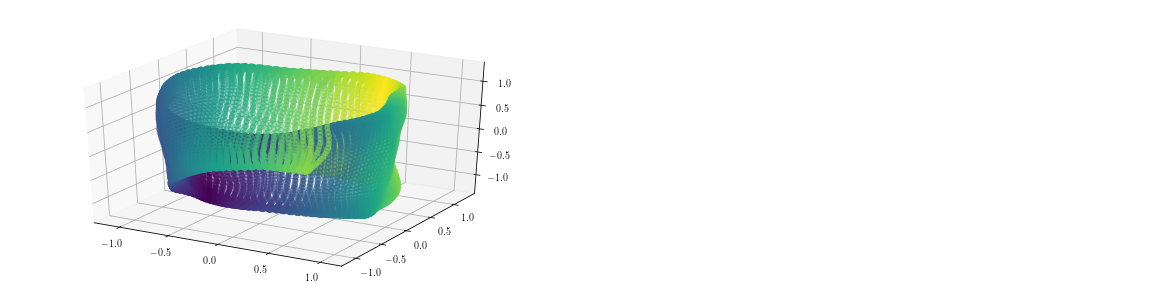

In [110]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g1fast, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)


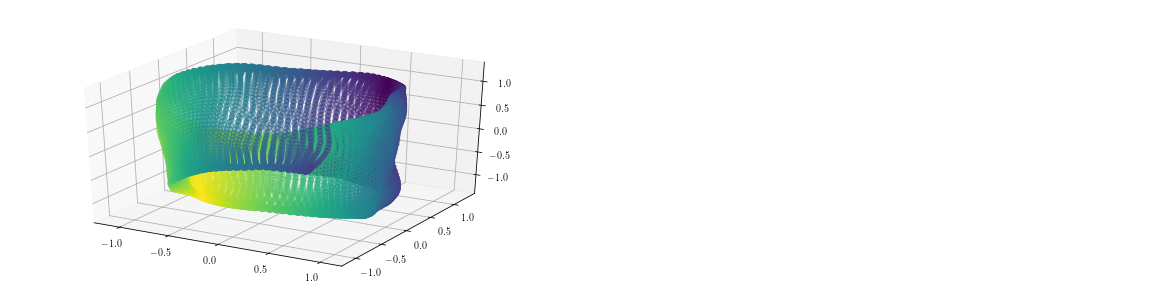

In [111]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g2fast, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)


In [116]:
import seaborn as sns

In [119]:
rezzie.max()

0.009473303986965572

In [120]:
rezzie.min()

0.0073909765989934465

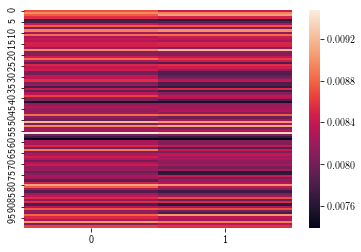

In [118]:
sns.heatmap(rezzie)

In [117]:
rezzie = np.linalg.norm(dg_M[:,:,np.where((np.linalg.norm(coeffsfast[probefast], axis = 0)**2).sum(axis = 1) != 0.)[0]], axis = 1)**2

In [121]:
rezzie = np.linalg.norm(dg_M, axis = 1)**2

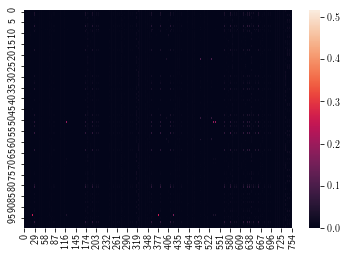

In [124]:
sns.heatmap(rezzie)

In [126]:
dnoise = 2
p  = 756

In [129]:
        parameterizations_possible = np.asarray(list(combinations(range(p), dnoise)))
        nparameterizations_possible = parameterizations_possible.shape[0]
        supports_brute = {}
        penalties = np.zeros((nreps, nparameterizations_possible))
        ols_norm = np.zeros((nreps, p, p))
    
        brute_coeffs = np.zeros((nsel, nparameterizations_possible, experiment.dim, experiment.q))
        
        orthogonality = np.zeros((nsel, nparameterizations_possible))
        r = 0
        for i in range(nsel):
            print(i)
            for j in range(nparameterizations_possible):
                brute_coeffs[i, j] = np.linalg.lstsq(replicates[r].dg_M[i, parameterizations_possible[j], :], replicates[r].df_M[i])[0]
                # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
        for j in range(nparameterizations_possible):
            penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
        for j in range(nparameterizations_possible):
            ols_norm[r, parameterizations_possible[j][0], parameterizations_possible[j][1]] = penalties[r, j]
            ols_norm[r, parameterizations_possible[j][1], parameterizations_possible[j][0]] = penalties[r, j]
        supports_brute[r] = parameterizations_possible[penalties[r, :].argmin()]

0


/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/autograd/tracer.py:48: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  return f_raw(*args, **kwargs)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [133]:
atoms4[supports_brute[0]]

array([[8, 3, 2, 6],
       [8, 5, 3, 6]])

In [135]:
g1brute =  experiment.get_g_full_sub(experiment.M.data, np.asarray([8, 3, 2, 6]))
g2brute = experiment.get_g_full_sub(experiment.M.data, np.asarray([8, 5, 3, 6]))#np.asarray([6, 4, 7, 8]))#np.asarray([2, 0, 6, 7]))

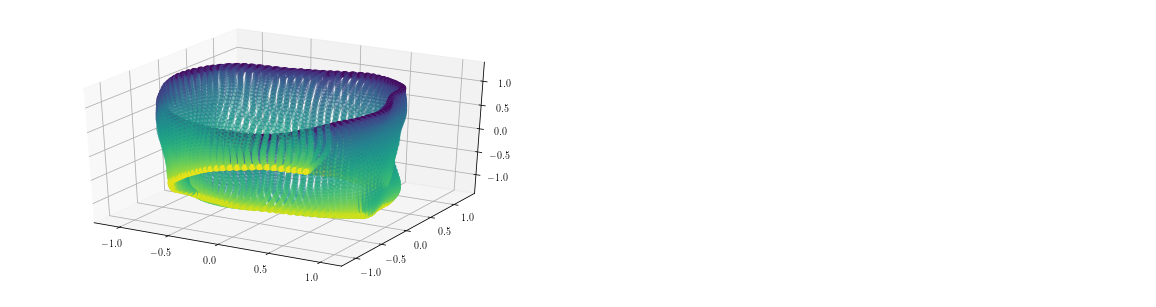

In [137]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g1brute, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)


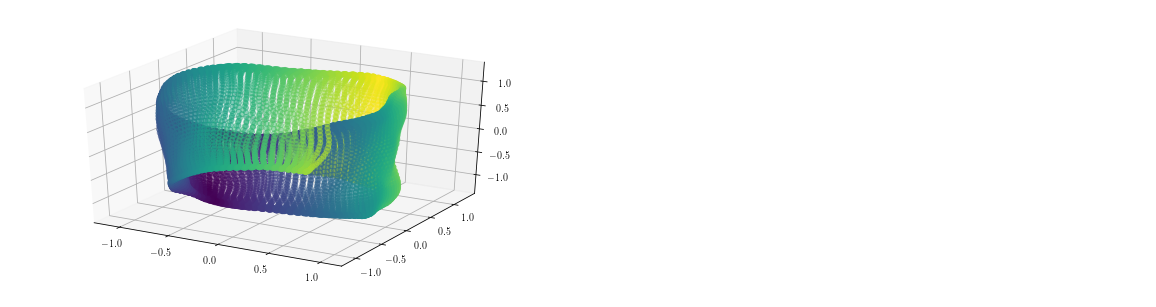

In [136]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g2brute, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)


In [ ]:

def get_olsnorm_and_supportsbrute(experiment, replicates):
    dim = experiment.dim
    dnoise = experiment.dnoise
    nreps = experiment.nreps
    nsel = experiment.nsel
    p = experiment.p

    parameterizations_possible = np.asarray(list(combinations(range(experiment.p), dnoise)))
    nparameterizations_possible = parameterizations_possible.shape[0]
    supports_brute = {}
    penalties = np.zeros((nreps, nparameterizations_possible))
    ols_norm = np.zeros((nreps, p, p))
    for r in range(nreps):
        brute_coeffs = np.zeros((nsel, nparameterizations_possible, experiment.dim, experiment.q))
        orthogonality = np.zeros((nsel, nparameterizations_possible))
        for i in range(nsel):
            for j in range(nparameterizations_possible):
                brute_coeffs[i, j] = np.linalg.lstsq(replicates[r].dg_M[i, parameterizations_possible[j], :], replicates[r].df_M[i])[0]
                # orthogonality[i,j] = get_penalty(brute_coeffs[i,j])
        for j in range(nparameterizations_possible):
            penalties[r, j] = experiment.compute_penalty2(np.expand_dims(brute_coeffs[:, j], 0))
        for j in range(nparameterizations_possible):
            ols_norm[r, parameterizations_possible[j][0], parameterizations_possible[j][1]] = penalties[r, j]
            ols_norm[r, parameterizations_possible[j][1], parameterizations_possible[j][0]] = penalties[r, j]
        supports_brute[r] = parameterizations_possible[penalties[r, :].argmin()]
    return (ols_norm, supports_brute)


In [125]:
rezzie.max()

0.5155543464889866

In [10]:
probe, coeffs, combined_norms = get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start, reg_l2,max_search, card, tol,learning_rate)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


KeyboardInterrupt: 

Process ForkPoolWorker-5:
Process ForkPoolWorker-4:
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 249, in _bootstrap
    self.run()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/pool.py", line 108, in worker
    task = get()
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/lib/python3.5/site-packages/multiprocess/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/samsonkoelle/anaconda3/envs/manifold_env_april/

In [29]:
gl_itermax = 500
probe, coeffs, combined_norms = get_sr_lambda_sam(dg_M, df_M, gl_itermax, lambdas_start, reg_l2,max_search, card, tol,learning_rate)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [77]:
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,learning_rate, tol, beta0_npm= None)
GGL.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [79]:
GGL.lossresults[0.043750000000000004][-10:]

[0.15625596307381595,
 0.15625596243208942,
 0.15625596179281223,
 0.1562559611556973,
 0.1562559605204394,
 0.1562559598867176,
 0.15625595925419747,
 0.15625595862253366,
 0.15625595799137204,
 0.15625595736035236]

In [80]:
(np.linalg.norm(GGL.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [81]:
GGL5k = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 5000,learning_rate, tol, beta0_npm= None)
GGL5k.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


In [82]:
(np.linalg.norm(GGL5k.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1)

array([0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 0.       , 0.       ,
       0.       , 0.       , 0.       , 0.       , 

In [84]:
GGL5k.lossresults[0.043750000000000004][-10:]

[0.15625591639082428,
 0.15625591640421854,
 0.15625591641760578,
 0.15625591643098583,
 0.15625591644435877,
 0.1562559164577245,
 0.15625591647108314,
 0.15625591648443465,
 0.156255916497779,
 0.15625591651111626]

In [85]:
GGL.lossresults[0.043750000000000004][-10:]

[0.15625596307381595,
 0.15625596243208942,
 0.15625596179281223,
 0.1562559611556973,
 0.1562559605204394,
 0.1562559598867176,
 0.15625595925419747,
 0.15625595862253366,
 0.15625595799137204,
 0.15625595736035236]

In [86]:
GGL5_5 = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,learning_rate, tol, beta0_npm= GGL.fit_[-1]['beta'])
GGL5_5.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [88]:
GGL5_5.lossresults[0.043750000000000004][:10]

[0.15878848506986623,
 0.15627076213007715,
 0.15627051508922668,
 0.15627023229648515,
 0.1562699152662869,
 0.15626956810951267,
 0.1562691957214942,
 0.15626880314239874,
 0.15626839542289545,
 0.15626797750630184]

In [89]:
GGL.lossresults[0.043750000000000004][:10]

[0.1587937460453376,
 0.1562707556324832,
 0.1562705087921325,
 0.15627022638921864,
 0.15626990982447816,
 0.1562695631673606,
 0.15626919130728228,
 0.15626879927695936,
 0.1562683921190692,
 0.15626797476888143]

In [90]:
GGL_lrfast =  GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,100*learning_rate, tol, beta0_npm= None)

In [91]:
GGL_lrfast.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [95]:
GGL_lrfast.lossresults[0.043750000000000004][-10:]

[0.1562558159367726,
 0.15625581593676938,
 0.1562558159367523,
 0.15625581593672486,
 0.15625581593669172,
 0.1562558159366582,
 0.156255815936629,
 0.15625581593660784,
 0.15625581593659676,
 0.15625581593659607]

In [97]:
(np.linalg.norm(GGL_lrfast.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [96]:
GGL5k.lossresults[0.043750000000000004][-10:]

[0.15625591639082428,
 0.15625591640421854,
 0.15625591641760578,
 0.15625591643098583,
 0.15625591644435877,
 0.1562559164577245,
 0.15625591647108314,
 0.15625591648443465,
 0.156255916497779,
 0.15625591651111626]

In [93]:
GGL.lossresults[0.043750000000000004][-10:]

[0.15625596307381595,
 0.15625596243208942,
 0.15625596179281223,
 0.1562559611556973,
 0.1562559605204394,
 0.1562559598867176,
 0.15625595925419747,
 0.15625595862253366,
 0.15625595799137204,
 0.15625595736035236]

In [98]:
GGL_lr10000 =  GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,10000*learning_rate, tol, beta0_npm= None)
GGL_lr10000.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [99]:
GGL_lr10000.lossresults[0.043750000000000004][-10:]

[0.15625581594518945,
 0.15625581594553045,
 0.15625581594587595,
 0.15625581594622592,
 0.15625581594658017,
 0.15625581594693852,
 0.156255815947301,
 0.1562558159476676,
 0.15625581594803797,
 0.15625581594841226]

In [101]:
GGL_lr1000000 =  GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,1000000*learning_rate, tol, beta0_npm= None)
GGL_lr1000000.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
GGL_lr =  GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,learning_rate, tol, beta0_npm= None)
GGL_lr.fit()

0
0 0.1
1
0 0.1
2
0 0.1
3
0 0.1
4
0 0.1
5
0 0.1
6
0 0.1
7
0 0.1
8
0 0.1
9
0 0.1
10
0 0.1
11
0 0.1
12
0 0.1
13
0 0.1
14
0 0.1
15
0 0.1
16
0 0.1
17
0 0.1
18
0 0.1
19
0 0.1
20
0 0.1
21
0 0.1
22
0 0.1
23
0 0.1
24
0 0.1
25
0 0.1
26
0 0.1
27
0 0.1
28
0 0.1
29
0 0.1
30
0 0.1
31
0 0.1
32
0 0.1
33
0 0.1
34
0 0.1
35
0 0.1
36
0 0.1
37
0 0.1
38
0 0.1
39
0 0.1
40
0 0.1
41
0 0.1
42
0 0.1
43
0 0.1
44
0 0.1
45
0 0.1
46
0 0.1
47
0 0.1
48
0 0.1
49
0 0.1
50
0 0.1
51
0 0.1
52
0 0.1
53
0 0.1
54
0 0.1
55
0 0.1
56
0 0.1
57
0 0.1
58
0 0.1
59
0 0.1
60
0 0.1
61
0 0.1
62
0 0.1
63
0 0.1
64
0 0.1
65
0 0.1
66
0 0.1
67
0 0.1
68
0 0.1
69
0 0.1
70
0 0.1
71
0 0.1
72
0 0.1
73
0 0.1
74
0 0.1
75
0 0.1
76
0 0.1
77
0 0.1
78
0 0.1
79
0 0.1
80
0 0.1
81
0 0.1
82
0 0.1
83
0 0.1
84
0 0.1
85
0 0.1
86
0 0.1
87
0 0.1
88
0 0.1
89
0 0.1
90
0 0.1
91
0 0.1
92
0 0.1
93
0 0.1
94
0 0.1
95
0 0.1
96
0 0.1
97
0 0.1
98
0 0.1
99
0 0.1
100
0 0.1
101
0 0.1
102
0 0.1
103
0 0.1
104
0 0.1
105
0 0.1
106
0 0.1
107
0 0.1
108
0 0.1
109
0 0.1
110
0 0.1


In [24]:
selected_points

array([9394,  898, 2398, 5906, 2343, 8225, 5506, 6451, 2670, 3497, 1087,
       1819, 2308, 6084, 3724, 3184, 6387, 3728, 2702, 7883, 2930, 5988,
       4890, 6718, 5423, 3213, 3017,  382, 4237, 4721, 9547, 9477, 4795,
       4747, 9366, 5334, 6652, 9032,  580, 9491, 6526, 4346, 4974, 7913,
       5611, 8480, 6625, 5615, 5602, 4857, 6734, 8451, 6332, 6798, 5313,
       2821, 9300, 2375, 1478, 5013, 1559, 8885, 3986, 4429, 3951, 2932,
       6419,  713, 8089, 6058, 8711, 4185, 4379, 7813,  843,  655, 7219,
        982, 7439, 8894,  598, 5350, 4221, 1422, 3646, 4387, 2606, 4228,
       1096, 8940, 5814, 3706, 2846,  467, 8314, 4595, 3725, 6450, 6846,
       3891])

In [23]:
np.max(dg_M)

0.7178646237447701

In [18]:
GGL_lr1000000 =  GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 500,1000000*learning_rate, tol, beta0_npm= None)
GGL_lr1000000.fit()

0
14 6.103515625
1
0 6.103515625
2
0 6.103515625
3
0 6.103515625
4
0 6.103515625
5
0 6.103515625
6
0 6.103515625
7
0 6.103515625
8
0 6.103515625
9
0 6.103515625
10
0 6.103515625
11
0 6.103515625
12
0 6.103515625
13
0 6.103515625
14
0 6.103515625
15
0 6.103515625
16
0 6.103515625
17
0 6.103515625
18
0 6.103515625
19
0 6.103515625
20
0 6.103515625
21
0 6.103515625
22
0 6.103515625
23
0 6.103515625
24
0 6.103515625
25
0 6.103515625
26
0 6.103515625
27
0 6.103515625
28
0 6.103515625
29
0 6.103515625
30
0 6.103515625
31
0 6.103515625
32
0 6.103515625
33
0 6.103515625
34
0 6.103515625
35
0 6.103515625
36
0 6.103515625
37
0 6.103515625
38
0 6.103515625
39
0 6.103515625
40
0 6.103515625
41
0 6.103515625
42
0 6.103515625
43
0 6.103515625
44
0 6.103515625
45
0 6.103515625
46
0 6.103515625
47
0 6.103515625
48
0 6.103515625
49
0 6.103515625
50
0 6.103515625
51
0 6.103515625
52
0 6.103515625
53
0 6.103515625
54
0 6.103515625
55
0 6.103515625
56
0 6.103515625
57
0 6.103515625
58
0 6.103515625
59
0 6

In [19]:
GGL_lr1000000.lossresults[0.043750000000000004][-30:]

[0.15625581595169025,
 0.15625581595209542,
 0.15625581595093468,
 0.1562558159485336,
 0.15625581594542146,
 0.15625581594220372,
 0.15625581593943527,
 0.1562558159375199,
 0.15625581593665108,
 0.1562558159368009,
 0.1562558159377531,
 0.15625581593916793,
 0.15625581594066262,
 0.15625581594189067,
 0.15625581594260324,
 0.1562558159426847,
 0.15625581594215854,
 0.15625581594116464,
 0.1562558159399181,
 0.15625581593865845,
 0.15625581593759943,
 0.15625581593689236,
 0.1562558159366032,
 0.1562558159367114,
 0.1562558159371235,
 0.156255815937701,
 0.1562558159382919,
 0.1562558159387615,
 0.15625581593901644,
 0.15625581593901755]

In [103]:
GGL_lr1000000.lossresults[0.043750000000000004][-30:]

[0.1562558159524794,
 0.15625581595045726,
 0.15625581594843344,
 0.15625581594645488,
 0.15625581594456645,
 0.15625581594280946,
 0.15625581594122095,
 0.15625581593983295,
 0.15625581593867183,
 0.15625581593775756,
 0.15625581593710341,
 0.15625581593671614,
 0.1562558159365954,
 0.15625581593673432,
 0.15625581593712007,
 0.15625581593773347,
 0.15625581593855062,
 0.1562558159395427,
 0.15625581594067792,
 0.15625581594192112,
 0.15625581594323565,
 0.15625581594458404,
 0.1562558159459286,
 0.15625581594723328,
 0.15625581594846333,
 0.15625581594958718,
 0.15625581595057658,
 0.15625581595140733,
 0.15625581595205984,
 0.15625581595251967]

In [104]:
(np.linalg.norm(GGL_lr1000000.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [ ]:
GGL50k = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 50000,learning_rate, tol, beta0_npm= None)
GGL50k.fit()

In [57]:
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 5000,learning_rate, tol, beta0_npm= coeffs[0.043750000000000004])
GGL.fit()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700


In [62]:
GGL.lossresults[0.043750000000000004][-10:]

[0.15625581814247047,
 0.15625581814594938,
 0.15625581814942902,
 0.15625581815290923,
 0.15625581815639014,
 0.15625581815987166,
 0.1562558181633538,
 0.1562558181668365,
 0.15625581817032008,
 0.15625581817380413]

In [70]:
GGL.lossresults[0.043750000000000004][:10]

[0.158803787081108,
 0.15627076362440107,
 0.15627051654713234,
 0.15627023363754552,
 0.15626991653915362,
 0.15626956930801372,
 0.15626919683877824,
 0.15626880417375683,
 0.1562683963653737,
 0.15626797835849543]

In [75]:
GGL2 = GradientGroupLasso(dg_M, df_M, np.asarray([0.043750000000000004]), reg_l2, 10,learning_rate, tol, beta0_npm= GGL.fit_[-1]['beta'])
GGL2.fit()

0
1
2
3
4
5
6
7
8
9


In [76]:
GGL2.lossresults

{0.043750000000000004: [0.15878743575518836,
  0.1562707666786721,
  0.1562705195680892,
  0.15627023652330765,
  0.15626991920469935,
  0.15626957172696157,
  0.15626919899335237,
  0.1562688060512704,
  0.15626839795786146,
  0.15626797966245132]}

In [74]:
(np.linalg.norm(GGL.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1)

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [69]:
combined_norms[0.043750000000000004]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [32]:
atoms4[np.where(combined_norms[0.043750000000000004] !=0)[0]]

array([[5, 4, 6, 8],
       [8, 5, 4, 6]])

In [35]:
g1 =  experiment.get_g_full_sub(experiment.M.data, np.asarray([5, 4, 6, 8]))
g2 = experiment.get_g_full_sub(experiment.M.data, np.asarray([8, 5, 4, 6]))#np.asarray([6, 4, 7, 8]))#np.asarray([2, 0, 6, 7]))

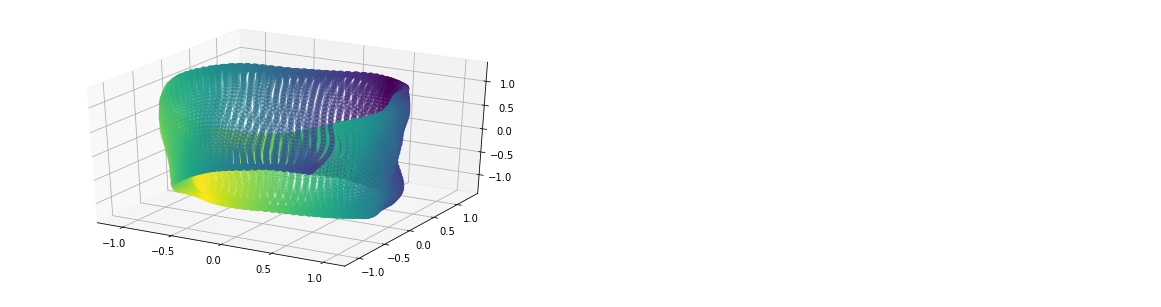

In [44]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]
#fig = plt.figure(figsize=(15,10))
#ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.scatter(x, y, z, c=g1, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)




#ax.set_xlabel(r'$\phi_1$', fontsize=30)
#ax.set_ylabel(r'$\phi_2$', fontsize=30)
#ax.set_zlabel(r'$\phi_3$', fontsize=30)
#ax.set_title(str(pairs[m][0]))

In [50]:


cs = rearrange(np.asarray(list(coeffs.values())), 'l n p m -> l m n p')
xaxis = np.asarray(list(coeffs.keys()))
xaxis_reorder = xaxis[xaxis.argsort()]
cs_reorder = cs[xaxis.argsort()]
xaxis_reorder = xaxis[xaxis.argsort()]
#replicates[r].cs_order = cs_reorder
#replicates[r].xaxis_reorder = xaxis_reorder

In [54]:

def plot_reg_path_ax_lambdasearch_customcolors_norm(ax, coeffs, xaxis,fig, colors):
    p = coeffs.shape[3]
    q = coeffs.shape[1]
    gnames = np.asarray(list(range(p)), dtype=str)

    rcParams['axes.titlesize'] = 30
    plt.rc('text', usetex=True)

    normax = np.sqrt(np.sum(np.sum(np.sum(coeffs ** 2, axis=1), axis=1), axis=1).max())

    for j in range(p):
        toplot = np.linalg.norm(np.linalg.norm(coeffs[:, :, :, j], axis=2), axis=1)
        # axes[0].boxplot(toplot, positions=xaxis, showfliers=False, vert=True, widths=widths,medianprops=dict(linestyle=''))
        ax.plot(xaxis, toplot, 'go--', linewidth=5, markersize=0, alpha=1.,
                     color=colors[j], label=gnames[j])

    kkk = xaxis.copy()
    kkk.sort()

    # xupperindex = np.min(np.where(np.sum(np.sum(np.sum(coeffs**2, axis = 1), axis = 1), axis = 1) ==0)[0])

    #for k in range(1 + q):
    ax.tick_params(labelsize=50)
    ax.set_xscale('symlog')
    ax.set_yscale('symlog')
    ax.set_ylim(bottom=0, top=normax)
    # axes[k].set_xlim(left = 0, right = xaxis[xupperindex])
    #if (k == 0):
    tixx = np.hstack(
        [np.asarray([0]), 10 ** np.linspace(math.floor(np.log10(normax)), math.floor(np.log10(normax)) + 1, 2)])
#    if k != 0:
        # axes[k].set_yticks(tixx)
    #ax.set_ylabel(r"$\displaystyle \|\hat \beta_{j}\|_2$", fontsize = 70)
    #ax.set_xlabel(r"$\lambda  \sqrt{nm}$", fontsize = 70)
    #ylabel = r"$\displaystyle \|\hat \beta_{j}\|_2$"
    #ax.l
    #if k == 0:
    #ax.set_title("Combined", fontdict={'fontsize': 50})
    ax.grid(True, which="both", alpha=True)

    #handles, labels = ax.get_legend_handles_labels()
    #by_label = OrderedDict(zip(labels, handles))
    # fig.text(0.5, 0.04, xlabel, ha='center', va='center', fontsize=50)
    # fig.text(0.05, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=60)
    #fig.subplots_adjust(right=0.75)
    #leg_ax = fig.add_axes([.8, 0.15, 0.05, 0.7])
    #leg_ax.axis('off')
    #leg = leg_ax.legend(by_label.values(), gnames, prop={'size': 200 / p})
    # leg.set_title('Torsion', prop={'size': Function})
    #for l in leg.get_lines():
    #    l.set_alpha(1)
    # fig.savefig(filename + 'beta_paths_n' + str(n) + 'nsel' + str(nsel) + 'nreps' + str(
    #    nreps))

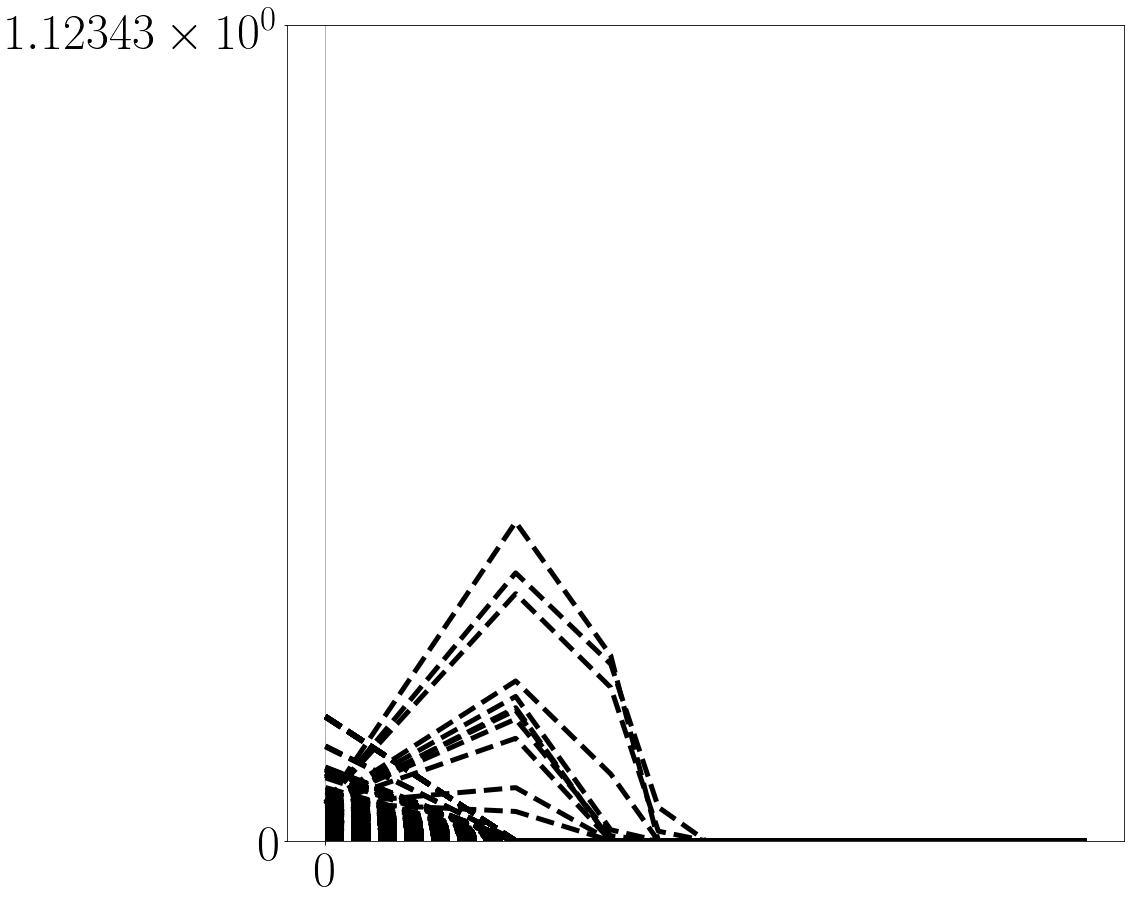

In [55]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15,15))
colors = np.repeat('black',756)
plot_reg_path_ax_lambdasearch_customcolors_norm(ax, cs_reorder, xaxis_reorder * np.sqrt(3 * 5), fig,colors)#axes_all[0].imshow(asdf)

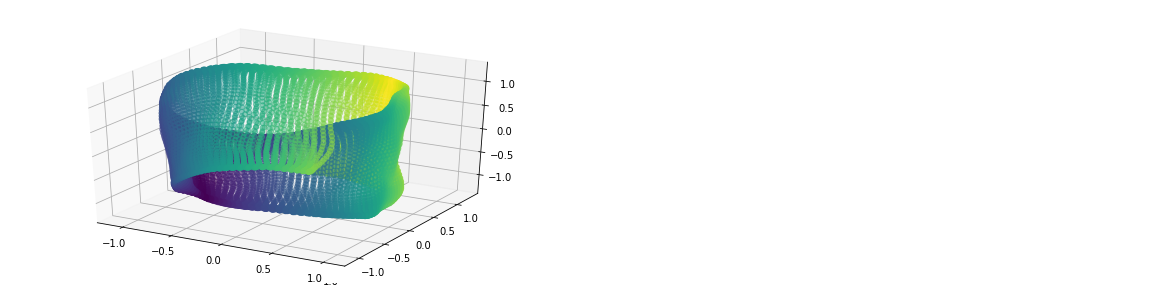

In [46]:
%matplotlib inline
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

fig, axs = plt.subplots(2,1, figsize = (20,5))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

axs[0].set_axis_off()
axs[1].set_axis_off()

ax = fig.add_subplot(1, 2, 1, projection='3d')

selected_points = list(range(10000))
x = data[:, 0][selected_points]
y = data[:, 1][selected_points]
z = data[:, 2][selected_points]

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.scatter(x, y, z, c=g2, s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)


In [ ]:
%matplotlib inline
fig, axs = plt.subplots(2,4, figsize = (30,10))
data = experiment.N.data
axes = [0,1,2]
s = 100
alpha = .5

for m in range(2):
    for n in range(4):
        axs[m,n].set_axis_off()
for m in range(2):
    ax = fig.add_subplot(2, 4, 1 + 4*m, projection='3d')
    c = gunits[pairs[m][0]]
    #axes[0,0] = 
    selected_points = list(range(10000))
    x = data[:, axes[0]][selected_points]
    y = data[:, axes[1]][selected_points]
    z = data[:, axes[2]][selected_points]
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c=c[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize=30)
    ax.set_ylabel(r'$\phi_2$', fontsize=30)
    ax.set_zlabel(r'$\phi_3$', fontsize=30)
    ax.set_title(str(pairs[m][0]))
    ax = fig.add_subplot(2, 4, 2 + 4*m, projection='3d')
    c = gunits[pairs[m][0]]
    #axes[0,0] = 
    selected_points = list(range(100))
    x = data[:, axes[0]][selected_points]
    y = data[:, axes[1]][selected_points]
    z = data[:, axes[2]][selected_points]
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c=c[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize=30)
    ax.set_ylabel(r'$\phi_2$', fontsize=30)
    ax.set_zlabel(r'$\phi_3$', fontsize=30)
    ax.set_title(str(pairs[m][0]))
    ax = fig.add_subplot(2, 4, 3 + 4*m, projection='3d')
    c = gunits[pairs[m][1]]
    #axes[0,0] = 
    selected_points = list(range(10000))
    x = data[:, axes[0]][selected_points]
    y = data[:, axes[1]][selected_points]
    z = data[:, axes[2]][selected_points]
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c=c[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize=30)
    ax.set_ylabel(r'$\phi_2$', fontsize=30)
    ax.set_zlabel(r'$\phi_3$', fontsize=30)
    ax.set_title(str(pairs[m][1]))
    ax = fig.add_subplot(2, 4, 4 + 4*m, projection='3d')
    c = gunits[pairs[m][1]]
    #axes[0,0] = 
    selected_points = list(range(100))
    x = data[:, axes[0]][selected_points]
    y = data[:, axes[1]][selected_points]
    z = data[:, axes[2]][selected_points]
    #fig = plt.figure(figsize=(15,10))
    #ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.scatter(x, y, z, c=c[selected_points], s=s, alpha=alpha, marker='.',vmin=0,vmax=np.pi)
    ax.set_xlabel(r'$\phi_1$', fontsize=30)
    ax.set_ylabel(r'$\phi_2$', fontsize=30)
    ax.set_zlabel(r'$\phi_3$', fontsize=30)
    ax.set_title(str(pairs[m][1]))
    #fig.set_clim(0,np.pi)

In [31]:
np.where(combined_norms[0.043750000000000004] !=0)[0]

(array([733, 734]),)

In [12]:
GGL = GradientGroupLasso(dg_M, df_M, np.asarray([0.016]), reg_l2, 500,learning_rate, tol)
GGL.fit()
coeffs[probe] = GGL.fit_[-1]['beta']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

NameError: name 'coeffs' is not defined

In [13]:
np.sqrt((np.linalg.norm(GGL.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [14]:
GGL.lossresults

{0.016: [0.15719802684070444,
  0.14981142501055753,
  0.143338890755537,
  0.137228299144011,
  0.1317445656515939,
  0.12705327229823782,
  0.12322469043706763,
  0.12022876678427522,
  0.1179716432150982,
  0.11632944415486493,
  0.11516896827874974,
  0.11437329199393814,
  0.1138496311375014,
  0.11349539483462778,
  0.11324747947088386,
  0.1130568284312599,
  0.11289458366208685,
  0.1127135340680078,
  0.1125146251673844,
  0.11228910672028392,
  0.11204359650448555,
  0.11179438561905482,
  0.11154139962189277,
  0.11128566455853409,
  0.11105474679809149,
  0.11087356709171828,
  0.11070363557627648,
  0.11054049840529787,
  0.11037878712406671,
  0.11021918776829388,
  0.11005981126848172,
  0.10990621834941264,
  0.10976030561281955,
  0.10964289187816562,
  0.10954578839223533,
  0.10947254081602553,
  0.10941682167512015,
  0.1093818186630916,
  0.1093478648172577,
  0.1093114928823144,
  0.10927040206934457,
  0.10922357878727748,
  0.1091711697894928,
  0.10911418828738

In [22]:
#why does including the b0 not help
#why can it go back up?
GGL2 = GradientGroupLasso(dg_M, df_M, np.asarray([0.016]), reg_l2, 500,learning_rate, tol, beta0_npm=GGL.fit_[-1]['beta'])
GGL2.fit(beta0_npm = GGL.fit_[-1]['beta'])
coeffs[probe] = GGL2.fit_[-1]['beta']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

NameError: name 'coeffs' is not defined

In [23]:
np.sqrt((np.linalg.norm(GGL2.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [24]:
GGL2.lossresults

{0.016: [0.10757509111073382,
  0.1075750834999416,
  0.10757507416122622,
  0.10757506319783827,
  0.10757505072547227,
  0.10757503686945097,
  0.10757502176177844,
  0.10757500553814364,
  0.10757498833495346,
  0.10757497028647119,
  0.10757495152212992,
  0.10757493216408426,
  0.10757491232505274,
  0.10757489210649351,
  0.10757487159714563,
  0.10757485087195412,
  0.10757482999138851,
  0.1075748090011508,
  0.10757478793225951,
  0.10757476680148684,
  0.10757474561211619,
  0.1075747243549815,
  0.10757470300974137,
  0.10757468154633949,
  0.10757465992659743,
  0.10757463810588665,
  0.10757461603482703,
  0.10757459366096173,
  0.1075745709303618,
  0.1075745477891208,
  0.10757452418470378,
  0.10757450006712466,
  0.10757447538993106,
  0.10757445011098529,
  0.10757442419303644,
  0.10757439760408602,
  0.10757437031755615,
  0.10757434231227439,
  0.10757431357229494,
  0.10757428408657807,
  0.10757425384855407,
  0.10757422285559781,
  0.10757419110844155,
  0.10757

In [25]:
#why does including the b0 not help
#why can it go back up?
GGL3 = GradientGroupLasso(dg_M, df_M, np.asarray([0.016]), reg_l2, 500,learning_rate, tol, beta0_npm=GGL2.fit_[-1]['beta'])
GGL3.fit(beta0_npm = GGL2.fit_[-1]['beta'])
#coeffs[probe] = GGL2.fit_[-1]['beta']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [26]:
GGL3.lossresults

{0.016: [0.10753382867553876,
  0.10753382711776568,
  0.10753382519211409,
  0.10753382291166835,
  0.10753382029139344,
  0.10753381734789128,
  0.10753381409913654,
  0.10753381056419688,
  0.1075338067629425,
  0.10753380271575078,
  0.10753379844321106,
  0.10753379396583493,
  0.10753378930377647,
  0.10753378447656775,
  0.10753377950287321,
  0.10753377440026676,
  0.1075337691850347,
  0.10753376387200717,
  0.10753375847441997,
  0.10753375300380752,
  0.10753374746992861,
  0.1075337418807239,
  0.10753373624230493,
  0.1075337305589738,
  0.1075337248332709,
  0.10753371906604928,
  0.10753371325657277,
  0.10753370740263439,
  0.10753370150069279,
  0.10753369554602224,
  0.1075336895328736,
  0.10753368345464184,
  0.10753367730403725,
  0.10753367107325679,
  0.10753366475415194,
  0.10753365833839089,
  0.10753365181761151,
  0.10753364518356354,
  0.10753363842823715,
  0.10753363154397735,
  0.10753362452358188,
  0.10753361736038285,
  0.10753361004831084,
  0.107533

In [27]:
np.sqrt((np.linalg.norm(GGL2.fit_[-1]['beta'], axis = 0)**2).sum(axis = 1))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     